# Feature Selection



In [19]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import catboost 
from catboost import Pool
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline
from copy import deepcopy

from bartpy.sklearnmodel import SklearnModel
from bartpy.featureselection import SelectNullDistributionThreshold, SelectSplitProportionThreshold
from bartpy.featureimportance import feature_importance
from bartpy.diagnostics.features import *

%matplotlib inline

Text(0.5, 1.0, 'X v y')

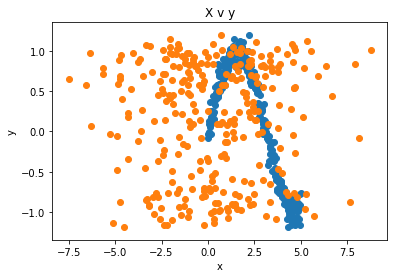

In [2]:
x = np.linspace(0, 5, 300)
X = np.random.normal(0, 3, size = 300 * 2).reshape(300, 2)
X[:, 0] = x
X = pd.DataFrame(X).sample(frac=1.0).values
y = np.random.normal(0, 0.1, size=300) + np.sin(X[:, 0])
plt.scatter(X[:, 0], y)
plt.scatter(X[:, 1], y)
plt.xlabel("x")
plt.ylabel("y")
plt.title("X v y")

In [3]:
model = SklearnModel(n_samples=200, n_burn=50, n_trees=50, store_in_sample_predictions=False, n_jobs=-1)
model.fit(X, y)

  4%|▍         | 2/50 [00:00<00:02, 17.40it/s]

Starting burn


  2%|▏         | 3/200 [00:00<00:09, 21.65it/s]

Starting sampling


  4%|▍         | 2/50 [00:00<00:02, 19.23it/s]

Starting burn


  2%|▏         | 3/200 [00:00<00:08, 22.44it/s]

Starting sampling


  4%|▍         | 2/50 [00:00<00:02, 19.09it/s]

Starting burn


  2%|▏         | 3/200 [00:00<00:09, 20.77it/s]

Starting sampling


  6%|▌         | 3/50 [00:00<00:02, 20.90it/s]

Starting burn


  2%|▏         | 3/200 [00:00<00:09, 21.72it/s]

Starting sampling


100%|██████████| 200/200 [00:09<00:00, 21.19it/s]


SklearnModel(alpha=0.95, beta=2.0, n_burn=50, n_chains=4, n_jobs=1,
             n_samples=200, n_trees=50, p_grow=0.5, p_prune=0.5, sigma_a=0.001,
             sigma_b=0.001, store_acceptance_trace=True,
             store_in_sample_predictions=False, thin=0.1)

In [4]:
len(model.extract[0]["acceptance"])

20

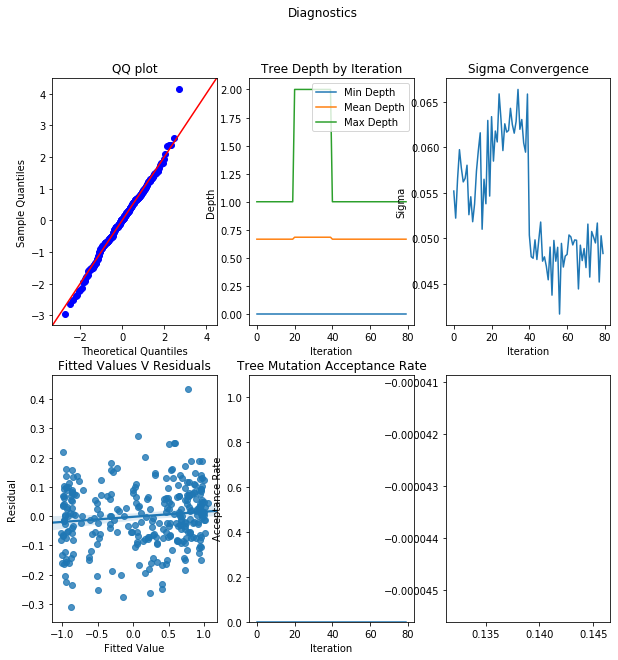

In [5]:
from matplotlib import pyplot as plt

from bartpy.diagnostics.residuals import plot_qq, plot_homoskedasity_diagnostics
from bartpy.diagnostics.sampling import plot_tree_mutation_acceptance_rate
from bartpy.diagnostics.sigma import plot_sigma_convergence
from bartpy.diagnostics.trees import plot_tree_depth
from bartpy.sklearnmodel import SklearnModel


def plot_diagnostics(model: SklearnModel):
    fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(10, 10))
    fig.suptitle("Diagnostics")
    plot_qq(model, ax1)
    plot_tree_depth(model, ax2)
    plot_sigma_convergence(model, ax3)
    plot_homoskedasity_diagnostics(model, ax4)
    plot_tree_mutation_acceptance_rate(model, ax5)
    plt.show()

plot_diagnostics(model)

(0, 1)

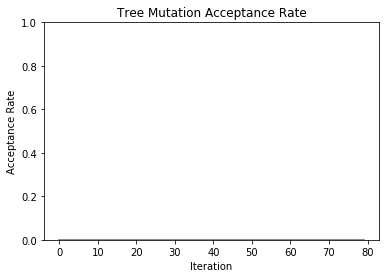

In [6]:
fig, ax = plt.subplots(1, 1)

ax.plot([x["Tree"] for x in model.acceptance_trace])
ax.set_title("Tree Mutation Acceptance Rate")
ax.set_xlabel("Iteration")
ax.set_ylabel("Acceptance Rate")
ax.set_ylim((0, 1))

# Sklearn API

Feature selection can be done in BartPy using the Sklearn selector API.  This allows for deep integration with the Sklearn pipelines

### Proportion Threshold

The simplest way to select features is to set a threshold on how often a variable is used in splits in the model trees.  The more times a tree appears in the model, the more likely it is that the feature is important and captures a meaningful pattern.

While this method is simple, the downside is that it is hard to set the threshold appropriately.  Cross validation is recommended

In [7]:
model = SklearnModel(n_samples=200, n_burn=50, n_trees=20, store_in_sample_predictions=False)
pipeline = make_pipeline(SelectSplitProportionThreshold(model, 0.3), model)
pipeline_model = pipeline.fit(X, y)

In [8]:
print("Feature Proportions", pipeline_model.named_steps["selectsplitproportionthreshold"].feature_proportions)
print("Is Kept", pipeline_model.named_steps["selectsplitproportionthreshold"]._get_support_mask())

Feature Proportions {0: 0.3853820598006645, 1: 0.2823920265780731}
Is Kept [ True False]


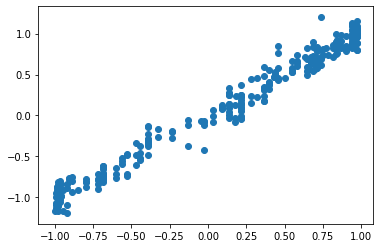

In [9]:
plt.scatter(model.predict(X), y)

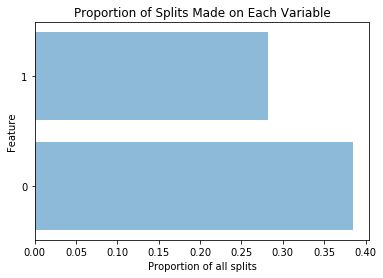

In [10]:
pipeline_model.named_steps["selectsplitproportionthreshold"].plot()

### Null Distribution Threshold

For a more principled analysis, BartPy implements the method described in https://repository.upenn.edu/cgi/viewcontent.cgi?article=1555&context=statistics_papers.

This is significantly more computationally expensive, but offers a principled way to set proportions

In [11]:
model = SklearnModel(n_samples=500, n_burn=200, n_trees=20, store_in_sample_predictions=False, n_jobs=-1)
pipeline = make_pipeline(SelectNullDistributionThreshold(model, 0.9, "local"), model)
pipeline_model = pipeline.fit(X, y)

  2%|▎         | 5/200 [00:00<00:04, 43.12it/s]

Starting burn


  1%|          | 6/500 [00:00<00:09, 50.76it/s]

Starting sampling


  3%|▎         | 6/200 [00:00<00:03, 55.83it/s]

Starting burn


  1%|          | 5/500 [00:00<00:09, 49.63it/s]

Starting sampling


  3%|▎         | 6/200 [00:00<00:03, 54.29it/s]

Starting burn


  1%|          | 6/500 [00:00<00:09, 54.46it/s]

Starting sampling


  3%|▎         | 6/200 [00:00<00:03, 48.70it/s]

Starting burn


  1%|          | 5/500 [00:00<00:10, 47.28it/s]

Starting sampling


  2%|▎         | 5/200 [00:00<00:04, 46.75it/s]

Starting burn


  1%|          | 5/500 [00:00<00:11, 43.73it/s]

Starting sampling


  2%|▎         | 5/200 [00:00<00:04, 46.50it/s]

Starting burn


  1%|          | 5/500 [00:00<00:10, 47.69it/s]

Starting sampling


  2%|▎         | 5/200 [00:00<00:03, 48.94it/s]

Starting burn


  1%|          | 5/500 [00:00<00:09, 49.64it/s]

Starting sampling


  2%|▎         | 5/200 [00:00<00:04, 47.16it/s]

Starting burn


  1%|          | 5/500 [00:00<00:11, 43.48it/s]

Starting sampling


  2%|▎         | 5/200 [00:00<00:04, 46.37it/s]

Starting burn


  1%|          | 5/500 [00:00<00:09, 49.98it/s]

Starting sampling


  2%|▎         | 5/200 [00:00<00:04, 46.52it/s]

Starting burn


  1%|          | 6/500 [00:00<00:08, 54.97it/s]

Starting sampling


  2%|▎         | 5/200 [00:00<00:03, 49.52it/s]

Starting burn


  1%|          | 6/500 [00:00<00:09, 53.58it/s]

Starting sampling


  3%|▎         | 6/200 [00:00<00:03, 50.64it/s]

Starting burn


  1%|          | 6/500 [00:00<00:09, 54.63it/s]

Starting sampling


  2%|▎         | 5/200 [00:00<00:04, 45.65it/s]

Starting burn


  1%|          | 6/500 [00:00<00:08, 55.61it/s]

Starting sampling


  3%|▎         | 6/200 [00:00<00:03, 50.98it/s]

Starting burn


  1%|          | 6/500 [00:00<00:09, 50.52it/s]

Starting sampling


  2%|▎         | 5/200 [00:00<00:04, 47.42it/s]

Starting burn


  1%|          | 6/500 [00:00<00:09, 52.38it/s]

Starting sampling


  3%|▎         | 6/200 [00:00<00:03, 53.05it/s]

Starting burn


  1%|          | 6/500 [00:00<00:09, 52.32it/s]

Starting sampling


  2%|▎         | 5/200 [00:00<00:04, 46.21it/s]

Starting burn


  1%|          | 6/500 [00:00<00:09, 53.55it/s]

Starting sampling


  3%|▎         | 6/200 [00:00<00:03, 56.38it/s]

Starting burn


  1%|          | 6/500 [00:00<00:08, 56.23it/s]

Starting sampling


  2%|▎         | 5/200 [00:00<00:03, 49.32it/s]

Starting burn


  1%|          | 6/500 [00:00<00:09, 50.72it/s]

Starting sampling


  2%|▎         | 5/200 [00:00<00:03, 49.40it/s]

Starting burn


  1%|          | 6/500 [00:00<00:09, 50.99it/s]

Starting sampling


  2%|▎         | 5/200 [00:00<00:04, 48.28it/s]

Starting burn


  1%|          | 5/500 [00:00<00:09, 49.90it/s]

Starting sampling


  2%|▎         | 5/200 [00:00<00:04, 42.94it/s]

Starting burn


  1%|          | 5/500 [00:00<00:10, 47.62it/s]

Starting sampling


  3%|▎         | 6/200 [00:00<00:03, 53.58it/s]

Starting burn


  1%|          | 6/500 [00:00<00:08, 56.63it/s]

Starting sampling


  2%|▎         | 5/200 [00:00<00:04, 48.24it/s]

Starting burn


  1%|          | 6/500 [00:00<00:09, 53.23it/s]

Starting sampling


  2%|▎         | 5/200 [00:00<00:04, 47.88it/s]

Starting burn


  1%|          | 6/500 [00:00<00:09, 52.65it/s]

Starting sampling


  3%|▎         | 6/200 [00:00<00:03, 52.31it/s]

Starting burn


  1%|          | 6/500 [00:00<00:08, 55.60it/s]

Starting sampling


  3%|▎         | 6/200 [00:00<00:03, 54.84it/s]

Starting burn


  1%|          | 6/500 [00:00<00:09, 50.49it/s]

Starting sampling


  3%|▎         | 6/200 [00:00<00:03, 50.63it/s]

Starting burn


  1%|          | 6/500 [00:00<00:08, 55.00it/s]

Starting sampling


  2%|▎         | 5/200 [00:00<00:04, 46.47it/s]

Starting burn


  1%|          | 6/500 [00:00<00:09, 52.81it/s]

Starting sampling


  3%|▎         | 6/200 [00:00<00:03, 50.79it/s]

Starting burn


  1%|          | 6/500 [00:00<00:08, 55.50it/s]

Starting sampling


  3%|▎         | 6/200 [00:00<00:03, 51.51it/s]

Starting burn


  1%|          | 6/500 [00:00<00:08, 55.49it/s]

Starting sampling


  2%|▎         | 5/200 [00:00<00:03, 49.50it/s]

Starting burn


  1%|          | 6/500 [00:00<00:09, 54.74it/s]

Starting sampling


  3%|▎         | 6/200 [00:00<00:03, 50.66it/s]

Starting burn


  1%|          | 6/500 [00:00<00:09, 54.85it/s]

Starting sampling


  3%|▎         | 6/200 [00:00<00:03, 52.29it/s]

Starting burn


  1%|          | 6/500 [00:00<00:09, 54.26it/s]

Starting sampling


  2%|▎         | 5/200 [00:00<00:03, 49.95it/s]

Starting burn


  1%|          | 5/500 [00:00<00:10, 47.84it/s]

Starting sampling


  2%|▎         | 5/200 [00:00<00:03, 48.80it/s]

Starting burn


  1%|          | 6/500 [00:00<00:09, 51.32it/s]

Starting sampling


  2%|▎         | 5/200 [00:00<00:04, 47.63it/s]

Starting burn


  1%|          | 6/500 [00:00<00:09, 52.53it/s]

Starting sampling


  3%|▎         | 6/200 [00:00<00:03, 50.34it/s]

Starting burn


  1%|          | 6/500 [00:00<00:09, 52.67it/s]

Starting sampling


  3%|▎         | 6/200 [00:00<00:03, 51.57it/s]

Starting burn


  1%|          | 6/500 [00:00<00:09, 52.29it/s]

Starting sampling


  3%|▎         | 6/200 [00:00<00:03, 52.69it/s]

Starting burn


  1%|          | 6/500 [00:00<00:09, 50.20it/s]

Starting sampling


  2%|▎         | 5/200 [00:00<00:03, 49.77it/s]

Starting burn


  1%|          | 6/500 [00:00<00:08, 55.71it/s]

Starting sampling


  3%|▎         | 6/200 [00:00<00:03, 51.77it/s]

Starting burn


  1%|          | 6/500 [00:00<00:09, 51.34it/s]

Starting sampling


  3%|▎         | 6/200 [00:00<00:03, 53.43it/s]

Starting burn


  1%|          | 6/500 [00:00<00:08, 55.40it/s]

Starting sampling


  3%|▎         | 6/200 [00:00<00:03, 52.55it/s]

Starting burn


  1%|          | 5/500 [00:00<00:10, 46.28it/s]

Starting sampling


  2%|▎         | 5/200 [00:00<00:04, 47.14it/s]

Starting burn


  1%|          | 6/500 [00:00<00:08, 56.63it/s]

Starting sampling


  2%|▎         | 5/200 [00:00<00:04, 48.22it/s]

Starting burn


  1%|          | 6/500 [00:00<00:09, 54.85it/s]

Starting sampling


  2%|▎         | 5/200 [00:00<00:04, 46.81it/s]

Starting burn


  1%|          | 6/500 [00:00<00:09, 52.52it/s]

Starting sampling


  2%|▎         | 5/200 [00:00<00:04, 47.72it/s]

Starting burn


  1%|          | 5/500 [00:00<00:09, 49.66it/s]

Starting sampling


100%|██████████| 500/500 [00:09<00:00, 53.42it/s]


In [12]:
import numpy as np
np.array([1, 2, 3,4]).reshape(2, 2)[:,]

array([[1, 2],
       [3, 4]])

In [13]:
print("Thresholds", pipeline_model.named_steps["selectnulldistributionthreshold"].thresholds)
print("Feature Proportions", pipeline_model.named_steps["selectnulldistributionthreshold"].feature_proportions)
print("Is Kept", pipeline_model.named_steps["selectnulldistributionthreshold"]._get_support_mask())

Thresholds {0: 0.2443666666666667, 1: 0.2715725806451613}
Feature Proportions {1: 0.38333333333333336, 0: 0.2833333333333333}
Is Kept [ True  True]


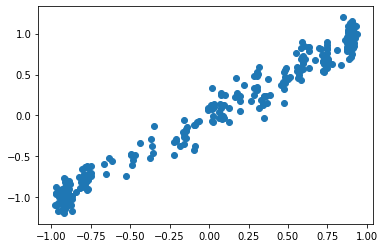

In [14]:
plt.scatter(model.predict(X), y)

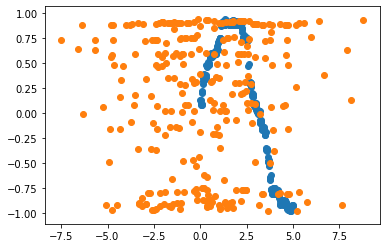

In [15]:
plt.scatter(X[:,0], model.predict(X))
plt.scatter(X[:,1], model.predict(X))

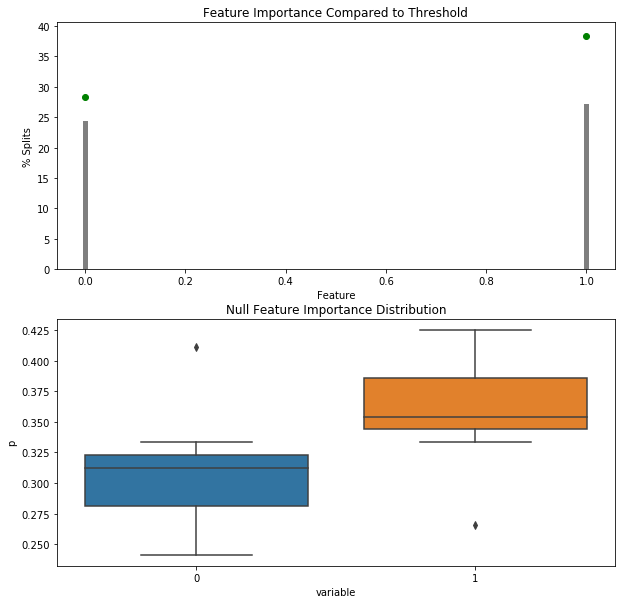

In [16]:
pipeline_model.named_steps["selectnulldistributionthreshold"].plot()

# Feature Selection

The approach so far is useful - but it doesn't give a complete picture of the importance of a single variable.  There are at least two big limitations:
1. % of splits doesn't give up an idea of how much a variable is improving accuracy
2. In cases of high correlation, the model might be able to as easily split on different variables

To get a more direct account of a single variable, we can instead permute that variable, and see how the out of sample RMSE changes.  The bigger the increase in RMSE that scrambling a variable, the more important the variable is.

  2%|▎         | 5/200 [00:00<00:04, 43.58it/s]

Starting burn


  2%|▏         | 12/500 [00:00<00:08, 55.23it/s]

Starting sampling


  3%|▎         | 6/200 [00:00<00:03, 54.01it/s]

Starting burn


  1%|          | 6/500 [00:00<00:09, 52.45it/s]

Starting sampling


  3%|▎         | 6/200 [00:00<00:03, 52.10it/s]

Starting burn


  1%|          | 6/500 [00:00<00:09, 51.71it/s]

Starting sampling


  3%|▎         | 6/200 [00:00<00:03, 52.64it/s]

Starting burn


  1%|          | 6/500 [00:00<00:08, 55.58it/s]

Starting sampling


  3%|▎         | 6/200 [00:00<00:03, 54.89it/s]

Starting burn


  1%|          | 6/500 [00:00<00:08, 55.97it/s]

Starting sampling


  3%|▎         | 6/200 [00:00<00:03, 54.56it/s]

Starting burn


  1%|          | 6/500 [00:00<00:09, 51.71it/s]

Starting sampling


  3%|▎         | 6/200 [00:00<00:03, 54.65it/s]

Starting burn


  1%|          | 6/500 [00:00<00:09, 53.97it/s]

Starting sampling


  3%|▎         | 6/200 [00:00<00:03, 53.78it/s]

Starting burn


  1%|          | 6/500 [00:00<00:08, 55.35it/s]

Starting sampling


  3%|▎         | 6/200 [00:00<00:03, 52.67it/s]

Starting burn


  1%|          | 6/500 [00:00<00:09, 51.14it/s]

Starting sampling


  3%|▎         | 6/200 [00:00<00:03, 50.50it/s]

Starting burn


  1%|          | 6/500 [00:00<00:09, 54.19it/s]

Starting sampling


  3%|▎         | 6/200 [00:00<00:03, 51.63it/s]

Starting burn


  2%|▏         | 12/500 [00:00<00:08, 54.65it/s]

Starting sampling


  3%|▎         | 6/200 [00:00<00:03, 54.08it/s]

Starting burn


  1%|          | 4/500 [00:00<00:14, 33.30it/s]

Starting sampling


  3%|▎         | 6/200 [00:00<00:03, 53.72it/s]

Starting burn


  2%|▏         | 11/500 [00:00<00:09, 53.01it/s]

Starting sampling


  3%|▎         | 6/200 [00:00<00:03, 52.45it/s]

Starting burn


  1%|          | 6/500 [00:00<00:09, 53.64it/s]

Starting sampling


  3%|▎         | 6/200 [00:00<00:03, 57.40it/s]

Starting burn


  1%|          | 6/500 [00:00<00:08, 54.99it/s]

Starting sampling


  3%|▎         | 6/200 [00:00<00:03, 55.75it/s]

Starting burn


  1%|          | 5/500 [00:00<00:10, 46.18it/s]

Starting sampling


  3%|▎         | 6/200 [00:00<00:03, 53.72it/s]

Starting burn


  1%|          | 6/500 [00:00<00:09, 54.02it/s]

Starting sampling


  3%|▎         | 6/200 [00:00<00:03, 53.63it/s]

Starting burn


  1%|          | 6/500 [00:00<00:09, 54.85it/s]

Starting sampling


  3%|▎         | 6/200 [00:00<00:03, 52.34it/s]

Starting burn


  1%|          | 6/500 [00:00<00:08, 54.92it/s]

Starting sampling


  3%|▎         | 6/200 [00:00<00:03, 54.32it/s]

Starting burn


  2%|▏         | 12/500 [00:00<00:08, 55.78it/s]

Starting sampling


  3%|▎         | 6/200 [00:00<00:03, 55.45it/s]

Starting burn


  2%|▏         | 12/500 [00:00<00:09, 52.01it/s]

Starting sampling


  3%|▎         | 6/200 [00:00<00:03, 53.94it/s]

Starting burn


  1%|          | 6/500 [00:00<00:09, 50.12it/s]

Starting sampling


  3%|▎         | 6/200 [00:00<00:03, 54.34it/s]

Starting burn


  2%|▏         | 11/500 [00:00<00:09, 52.49it/s]

Starting sampling


  2%|▎         | 5/200 [00:00<00:03, 49.16it/s]

Starting burn


  1%|          | 6/500 [00:00<00:09, 53.84it/s]

Starting sampling


  3%|▎         | 6/200 [00:00<00:03, 53.00it/s]

Starting burn


  1%|          | 6/500 [00:00<00:09, 50.43it/s]

Starting sampling


  3%|▎         | 6/200 [00:00<00:03, 56.05it/s]

Starting burn


  1%|          | 6/500 [00:00<00:08, 55.63it/s]

Starting sampling


  3%|▎         | 6/200 [00:00<00:03, 51.96it/s]

Starting burn


  1%|          | 6/500 [00:00<00:08, 55.37it/s]

Starting sampling


  3%|▎         | 6/200 [00:00<00:03, 53.26it/s]

Starting burn


  2%|▏         | 12/500 [00:00<00:09, 53.18it/s]

Starting sampling


  3%|▎         | 6/200 [00:00<00:03, 54.03it/s]

Starting burn


  2%|▏         | 11/500 [00:00<00:09, 51.84it/s]

Starting sampling


  2%|▎         | 5/200 [00:00<00:03, 49.81it/s]

Starting burn


  1%|          | 6/500 [00:00<00:08, 58.22it/s]

Starting sampling


  3%|▎         | 6/200 [00:00<00:03, 54.31it/s]

Starting burn


  1%|          | 6/500 [00:00<00:08, 59.69it/s]

Starting sampling


  3%|▎         | 6/200 [00:00<00:03, 52.60it/s]

Starting burn


  1%|          | 6/500 [00:00<00:09, 52.17it/s]

Starting sampling


  3%|▎         | 6/200 [00:00<00:03, 53.43it/s]

Starting burn


  1%|          | 6/500 [00:00<00:09, 50.44it/s]

Starting sampling


  3%|▎         | 6/200 [00:00<00:03, 53.38it/s]

Starting burn


  1%|          | 6/500 [00:00<00:09, 53.77it/s]

Starting sampling


  3%|▎         | 6/200 [00:00<00:03, 53.97it/s]

Starting burn


  1%|          | 6/500 [00:00<00:08, 57.02it/s]

Starting sampling


  3%|▎         | 6/200 [00:00<00:03, 56.31it/s]

Starting burn


  1%|          | 6/500 [00:00<00:09, 54.19it/s]

Starting sampling


  3%|▎         | 6/200 [00:00<00:03, 53.65it/s]

Starting burn


  1%|          | 6/500 [00:00<00:08, 56.10it/s]

Starting sampling


  3%|▎         | 6/200 [00:00<00:03, 54.07it/s]

Starting burn


  2%|▏         | 12/500 [00:00<00:09, 52.21it/s]

Starting sampling


  3%|▎         | 6/200 [00:00<00:03, 54.39it/s]

Starting burn


  1%|          | 6/500 [00:00<00:08, 55.43it/s]

Starting sampling


  3%|▎         | 6/200 [00:00<00:03, 55.09it/s]

Starting burn


  1%|          | 6/500 [00:00<00:09, 53.66it/s]

Starting sampling


  3%|▎         | 6/200 [00:00<00:03, 54.12it/s]

Starting burn


  1%|          | 6/500 [00:00<00:09, 53.85it/s]

Starting sampling


  3%|▎         | 6/200 [00:00<00:03, 52.96it/s]

Starting burn


  1%|          | 6/500 [00:00<00:08, 58.54it/s]

Starting sampling


  3%|▎         | 6/200 [00:00<00:03, 52.40it/s]

Starting burn


  1%|          | 6/500 [00:00<00:08, 56.92it/s]

Starting sampling


  3%|▎         | 6/200 [00:00<00:03, 53.54it/s]

Starting burn


  2%|▏         | 12/500 [00:00<00:09, 53.37it/s]

Starting sampling


  3%|▎         | 6/200 [00:00<00:03, 53.54it/s]

Starting burn


  1%|          | 6/500 [00:00<00:08, 54.99it/s]

Starting sampling


  3%|▎         | 6/200 [00:00<00:03, 53.28it/s]

Starting burn


  1%|          | 6/500 [00:00<00:08, 56.15it/s]

Starting sampling


  3%|▎         | 6/200 [00:00<00:03, 55.68it/s]

Starting burn


  3%|▎         | 13/500 [00:00<00:08, 57.62it/s]

Starting sampling


  3%|▎         | 6/200 [00:00<00:03, 52.83it/s]

Starting burn


  1%|          | 6/500 [00:00<00:09, 54.14it/s]

Starting sampling


  3%|▎         | 6/200 [00:00<00:03, 52.25it/s]

Starting burn


  1%|          | 6/500 [00:00<00:08, 55.07it/s]

Starting sampling


  3%|▎         | 6/200 [00:00<00:03, 53.94it/s]

Starting burn


  1%|          | 6/500 [00:00<00:09, 54.53it/s]

Starting sampling


  3%|▎         | 6/200 [00:00<00:03, 53.27it/s]

Starting burn


  1%|          | 6/500 [00:00<00:09, 54.74it/s]

Starting sampling


  3%|▎         | 6/200 [00:00<00:03, 51.76it/s]

Starting burn


  1%|          | 6/500 [00:00<00:09, 51.19it/s]

Starting sampling


  3%|▎         | 6/200 [00:00<00:03, 57.40it/s]

Starting burn


  2%|▏         | 12/500 [00:00<00:08, 54.40it/s]

Starting sampling


  3%|▎         | 6/200 [00:00<00:03, 52.92it/s]

Starting burn


  1%|          | 6/500 [00:00<00:09, 54.55it/s]

Starting sampling


  3%|▎         | 6/200 [00:00<00:03, 54.81it/s]

Starting burn


  1%|          | 6/500 [00:00<00:09, 54.84it/s]

Starting sampling


  3%|▎         | 6/200 [00:00<00:03, 56.91it/s]

Starting burn


  2%|▏         | 12/500 [00:00<00:09, 53.66it/s]

Starting sampling


  3%|▎         | 6/200 [00:00<00:03, 53.32it/s]

Starting burn


  2%|▏         | 12/500 [00:00<00:08, 55.07it/s]

Starting sampling


  3%|▎         | 6/200 [00:00<00:03, 54.12it/s]

Starting burn


  1%|          | 5/500 [00:00<00:10, 49.09it/s]

Starting sampling


  3%|▎         | 6/200 [00:00<00:03, 54.25it/s]

Starting burn


  1%|          | 6/500 [00:00<00:09, 53.25it/s]

Starting sampling


  3%|▎         | 6/200 [00:00<00:03, 52.89it/s]

Starting burn


  1%|          | 6/500 [00:00<00:08, 58.07it/s]

Starting sampling


  3%|▎         | 6/200 [00:00<00:03, 52.33it/s]

Starting burn


  1%|          | 6/500 [00:00<00:09, 50.63it/s]

Starting sampling


  3%|▎         | 6/200 [00:00<00:03, 54.95it/s]

Starting burn


  1%|          | 6/500 [00:00<00:08, 55.77it/s]

Starting sampling


  3%|▎         | 6/200 [00:00<00:03, 55.61it/s]

Starting burn


  2%|▏         | 12/500 [00:00<00:09, 52.24it/s]

Starting sampling


  3%|▎         | 6/200 [00:00<00:03, 51.88it/s]

Starting burn


  1%|          | 6/500 [00:00<00:08, 56.66it/s]

Starting sampling


  3%|▎         | 6/200 [00:00<00:03, 55.68it/s]

Starting burn


  2%|▏         | 12/500 [00:00<00:08, 54.84it/s]

Starting sampling


  3%|▎         | 6/200 [00:00<00:03, 52.88it/s]

Starting burn


  1%|          | 5/500 [00:00<00:10, 49.47it/s]

Starting sampling


  3%|▎         | 6/200 [00:00<00:03, 53.29it/s]

Starting burn


  1%|          | 6/500 [00:00<00:09, 53.16it/s]

Starting sampling


  3%|▎         | 6/200 [00:00<00:03, 51.83it/s]

Starting burn


  1%|          | 6/500 [00:00<00:08, 56.35it/s]

Starting sampling


  3%|▎         | 6/200 [00:00<00:03, 53.83it/s]

Starting burn


  1%|          | 6/500 [00:00<00:09, 54.13it/s]

Starting sampling


  3%|▎         | 6/200 [00:00<00:03, 53.88it/s]

Starting burn


  1%|          | 6/500 [00:00<00:09, 51.88it/s]

Starting sampling


  3%|▎         | 6/200 [00:00<00:03, 53.43it/s]

Starting burn


  1%|          | 6/500 [00:00<00:08, 55.10it/s]

Starting sampling


  3%|▎         | 6/200 [00:00<00:03, 57.23it/s]

Starting burn


  1%|          | 5/500 [00:00<00:09, 49.77it/s]

Starting sampling


  3%|▎         | 6/200 [00:00<00:03, 55.52it/s]

Starting burn


  1%|          | 6/500 [00:00<00:09, 53.87it/s]

Starting sampling


  3%|▎         | 6/200 [00:00<00:03, 53.52it/s]

Starting burn


  1%|          | 6/500 [00:00<00:08, 55.59it/s]

Starting sampling


  3%|▎         | 6/200 [00:00<00:03, 55.60it/s]

Starting burn


  1%|          | 6/500 [00:00<00:09, 52.90it/s]

Starting sampling


  3%|▎         | 6/200 [00:00<00:03, 51.75it/s]

Starting burn


  1%|          | 6/500 [00:00<00:08, 55.70it/s]

Starting sampling


  3%|▎         | 6/200 [00:00<00:03, 55.61it/s]

Starting burn


  1%|          | 6/500 [00:00<00:09, 53.71it/s]

Starting sampling


  3%|▎         | 6/200 [00:00<00:03, 51.81it/s]

Starting burn


  2%|▏         | 11/500 [00:00<00:09, 50.52it/s]

Starting sampling


  3%|▎         | 6/200 [00:00<00:03, 52.73it/s]

Starting burn


  1%|          | 5/500 [00:00<00:09, 49.77it/s]

Starting sampling


  3%|▎         | 6/200 [00:00<00:03, 52.02it/s]

Starting burn


  1%|          | 6/500 [00:00<00:09, 52.78it/s]

Starting sampling


  3%|▎         | 6/200 [00:00<00:03, 53.59it/s]

Starting burn


  1%|          | 6/500 [00:00<00:09, 52.33it/s]

Starting sampling


  3%|▎         | 6/200 [00:00<00:03, 55.49it/s]

Starting burn


  1%|          | 6/500 [00:00<00:09, 50.26it/s]

Starting sampling


  3%|▎         | 6/200 [00:00<00:03, 58.92it/s]

Starting burn


  1%|          | 6/500 [00:00<00:09, 54.43it/s]

Starting sampling


  2%|▎         | 5/200 [00:00<00:03, 49.15it/s]

Starting burn


  1%|          | 5/500 [00:00<00:10, 48.72it/s]

Starting sampling


  3%|▎         | 6/200 [00:00<00:03, 54.01it/s]

Starting burn


  1%|          | 6/500 [00:00<00:10, 48.86it/s]

Starting sampling


  3%|▎         | 6/200 [00:00<00:03, 55.11it/s]

Starting burn


  1%|          | 6/500 [00:00<00:09, 52.27it/s]

Starting sampling


  3%|▎         | 6/200 [00:00<00:03, 52.29it/s]

Starting burn


  2%|▏         | 12/500 [00:00<00:08, 55.04it/s]

Starting sampling


  3%|▎         | 6/200 [00:00<00:03, 53.04it/s]

Starting burn


  2%|▏         | 12/500 [00:00<00:08, 56.17it/s]

Starting sampling


100%|██████████| 500/500 [00:09<00:00, 53.10it/s]


([1.6247928432799925, 1.698503184141286],
 [12.82764695655568,
  8.645546513783449,
  8.740041048069546,
  8.65532768515795,
  8.646494153834402,
  8.741538347535718,
  8.650024199394633,
  8.647583207392541,
  8.767603948663599,
  8.66557891731043,
  9.138510731500178,
  9.200917348239663,
  9.37660080878046,
  9.247541322428205,
  9.295533175714075,
  9.31522155291682,
  9.301234358914108,
  9.243898940902367,
  9.328408692205636,
  9.272630526659178])

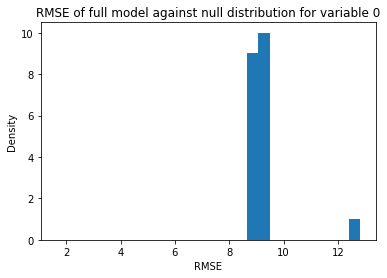

In [20]:
feature_importance(model, X, y, 0)

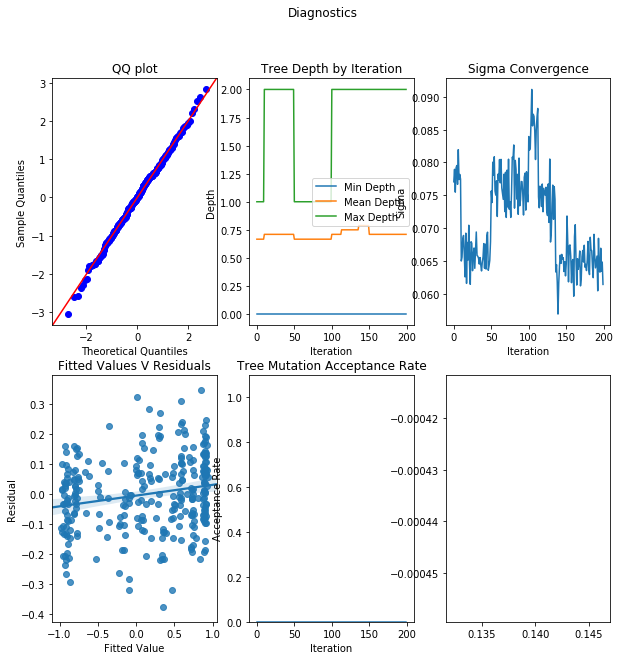

In [18]:
from bartpy.diagnostics.diagnostics import plot_diagnostics
plot_diagnostics(model)